# Enhanced Offshore Earthquake Monitoring by DAS Denoising

**Authors: Qibin Shi (qibins@uw.edu/ qshi003@e.ntu.edu.sg), Marine Denolle (mdenolle@uw.edu)**

This notebook is created originally to analyze the Alaska DAS data maintained by the UWQuake research group.

It has 4 sessions. Each session will save the essential results for the next steps. 

For optimized experience, we recommend:

1. GPU

2. H5 file format

### Import modules before any session

In [50]:
import sys
sys.path.append('../src/denoiser/')
import h5py
import datetime
import pandas as pd
from tqdm import tqdm
from obspy import read_events
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime
from distaz import DistAz
from joblib import Parallel, delayed
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

from das_util import try_gpu
from das_denoise_models import unet

import numpy as np
import torch
import torch.nn as nn

import matplotlib
%matplotlib agg
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

### Parameters for DAS 
sample_rate = 25
dchan = 9.5714
ch_max = 4500  # max channel of each cable (4500 or 6000)
ch_itv=2  # channels are downsampled for faster picking

### Directories and files
raw_dir = '/fd1/QibinShi_data/akdas/qibin_data/'
out_dir = raw_dir + 'largerEQ_plots_test_picking_dec_ch' + str(ch_max) + '/'
record_time_file = 'recording_times_larger.csv'
qml = raw_dir + 'ak_Dec1_31_a120b065.xml'


############################ Functions for this notebook

### Functions to calculate P and S time on arrays
### Travel time for given channels
def array_tpts(i, stla, stlo, evla, evlo, evdp):
    
    distdeg = DistAz(stla[i], stlo[i], evla, evlo).getDelta()
    tp = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['p', 'P'])
    ts = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['s', 'S'])
    return [tp[0].time, ts[0].time]


### Add travel time for AK DAS arrays to dataframe
def akdas_tpts(cat, eid, kkfls, terra, correct_terra):
    ### Event info
    evt = cat[eid]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000 + 2.0  ## too shallow depth+ long distance = bugs
    ort = evt.origins[0].time
    
    mag0,lon0,lat0,dep0,ort0=round(mag,1),round(lon,2),round(lat,2),round(dep,0),ort.strftime('%Y-%m-%d')

    ### array info
    t_kkfls=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,kkfls['lat'].values,kkfls['lon'].values,lat,lon,dep) 
                                           for ch in range(len(kkfls))))
    t_terra=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,terra['lat'].values,terra['lon'].values,lat,lon,dep) 
                                           for ch in range(len(terra))))

    kkfls['tp'] = t_kkfls[:, 0]
    kkfls['ts'] = t_kkfls[:, 1]
    terra['tp'] = t_terra[:, 0]+correct_terra
    terra['ts'] = t_terra[:, 1]+correct_terra
    
    return kkfls, terra, mag0,lon0,lat0,dep0,ort0


### Functions to denoise large-N DAS array
def process_3d_array(arr, len1=1500, len2=1500):
    """convert to numpy array"""
    arr = np.array(arr)
    
    """Ensure the array has at least len1 rows and len2 columns"""
    slices, rows, cols = arr.shape
    arr = arr[:, :min(rows, len1), :min(cols, len2)]
    
    """Pad zeros if it has fewer than len1 rows or len2 columns"""
    if rows < len1 or cols < len2:
        padding_rows = max(len1 - rows, 0)
        padding_cols = max(len2 - cols, 0)
        arr = np.pad(arr, ((0, 0), (0, padding_rows), (0, padding_cols)), 'constant')
    
    return arr


def Denoise_largeDAS(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT filter data):
    1) split into multiple 1500-channel segments
    2) call Denoise function for each segments
    3) merge all segments
    
    data: 2D -- [channel, time]
    output: 2D, but padded 0 to have multiple of 1500 channels
    
    This code was primarily designed for the Alaska DAS, but applicable to other networks
    """ 
    data = np.array(data)
    nchan = data.shape[0]
    ntime = data.shape[1]
    
    if (nchan // 1500) == 0:
        n_seg = nchan // 1500
    else:
        n_seg = nchan // 1500 + 1
        
    full_len = int(n_seg * 1500)
    
    pad_data = process_3d_array(data[np.newaxis,:,:], len1=full_len)
    data3d = pad_data.reshape((-1, 1500, 1500))
    
    oneDenoise, mulDenoise = Denoise(data3d, model_func, devc, repeat=repeat, norm_batch=norm_batch)
    
    oneDenoise2d = oneDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    mulDenoise2d = mulDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    
    return oneDenoise2d, mulDenoise2d
    

def Denoise(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT initialize model):

    1) normalized the data
    2) ensure the data format, precision and size
    3) denoise and scale back the output amplitude
    """ 
    
    """ convert to torch tensors """
    if norm_batch:
        scale = np.std(data[-1]) + 1e-7  ### Avoid potentially bad beginning sub-images
    else:
        scale = np.std(data, axis=(1,2), keepdims=True) + 1e-7
        
    data_norm = data / scale  ## standard scaling
    arr = process_3d_array(data_norm.astype(np.float32))
    X = torch.from_numpy(arr).to(devc)
    
    """ denoise - deploy """
    with torch.no_grad():
        oneDenoise = model_func(X)
        mulDenoise = oneDenoise
        
        for i in range(repeat-1):
            mulDenoise = model_func(mulDenoise)

    """ convert back to numpy """
    oneDenoise = oneDenoise.to('cpu').numpy() * scale
    mulDenoise = mulDenoise.to('cpu').numpy() * scale
    
    return oneDenoise[:, :len(data[0]), :len(data[0][0])], mulDenoise[:, :len(data[0]), :len(data[0][0])]

def vizRawDenoise(in_data, oneDenoise, mulDenoise, sample_rate=25, dchan=10, index=[0,1], model="MAE"):
    """
    in_data, oneDenoise, mulDenoise: 3D -- [event, channel, time]
    index: list, subset of the events
    model: string, descriptions about the model
    """
    len1, len2 = oneDenoise[0].shape[0], oneDenoise[0].shape[1]
    x, y = np.arange(len2)/sample_rate, np.arange(0-len1/2, len1/2)*dchan/1000
    rawdata = process_3d_array(in_data, len1=len1, len2=len2)
    
    matplotlib.rcParams['font.size'] = 20

    for j in index:
        bound = np.percentile(np.fabs(in_data[j]), 80)
        cmp = matplotlib.colormaps['RdBu']
        fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

        img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
        ax[1].pcolormesh(x, y, oneDenoise[j], shading='auto',  vmin=-bound, vmax=bound, cmap=cmap)
        ax[2].pcolormesh(x, y, mulDenoise[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap)

        ax[0].set_title("Raw data #"+str(j))
        ax[1].set_title(model+" 1-time denoised")
        ax[2].set_title(model+" multi-time denoised")
        ax[0].set_ylabel('Distance (km)')
        ax[0].set_xlabel('Time (s)')
        ax[1].set_xlabel('Time (s)')
        ax[2].set_xlabel('Time (s)')

        plt.colorbar(img, ax=ax[2], aspect=50)


### Functions to pick large DAS arrays
def process_p(ista,paras_semblance,batch_pred,istart,sfs):
    
        crap = ensemble_semblance(batch_pred[:, ista, :], paras_semblance)
        imax = np.argmax(crap[istart:])
            
        return float((imax)/sfs)+istart/sfs, crap[istart+imax]
    

def apply_elep(DAS_data, list_models, fs, paras_semblance, device):
    
    """"
    This function takes a array of stream, a list of ML models and 
    apply these models to the data, predict phase picks, and
    return an array of picks .
    DAS_data: NDArray of DAS data: [channel,time stamp - 6000]
    """
    
    twin = 6000  ## needed by EQTransformer
    nsta = DAS_data.shape[0]
    bigS = np.zeros(shape=(DAS_data.shape[0], 3, DAS_data.shape[1]))
    for i in range(nsta):   ### same data copied to three components
        bigS[i,0,:] = DAS_data[i,:]
        bigS[i,1,:] = DAS_data[i,:]
        bigS[i,2,:] = DAS_data[i,:]

    # allocating memory for the ensemble predictions
    batch_pred_P = np.zeros(shape=(len(list_models),nsta,twin)) 
    batch_pred_S = np.zeros(shape=(len(list_models),nsta,twin))
        
    ######### Broadband workflow ################
    crap2 = bigS.copy()
    crap2 -= np.mean(crap2, axis=-1, keepdims= True) # demean data
    # original use std norm
    data_std = crap2 / (np.std(crap2) + 1e-7)
    # could use max data
    mmax = np.max(np.abs(crap2), axis=-1, keepdims=True)
    data_max = np.divide(crap2 , mmax,out=np.zeros_like(crap2), where=mmax!=0)
    del bigS
    
    # data to tensor
    data_tt = torch.from_numpy(data_max).to(device, dtype=torch.float64)
    
    for ii, imodel in enumerate(list_models):
        imodel.to(device)
        imodel=imodel.double()
        imodel.eval()
        with torch.no_grad():
            batch_pred_P[ii, :, :] = imodel(data_tt)[1].cpu().numpy()[:, :]
            batch_pred_S[ii, :, :] = imodel(data_tt)[2].cpu().numpy()[:, :]
    
    smb_peak = np.zeros([nsta,2,2], dtype = np.float32)

    smb_peak[:,0,:] =np.array(Parallel(n_jobs=100)(delayed(process_p)(ista,paras_semblance,batch_pred_P,0,fs) 
                                                    for ista in range(nsta)))
    smb_peak[:,1,:] =np.array(Parallel(n_jobs=100)(delayed(process_p)(ista,paras_semblance,batch_pred_S,0,fs) 
                                                    for ista in range(nsta)))
    
    return smb_peak


### plotting codes to simplify massive event processing

### plot picked times
def subfig_img(image, pick, ind_p, ind_s, pred, array, title, colors=['blue', 'green']):
    x = np.arange(image.shape[1])/fs
    y = np.arange(0-image.shape[0]/2,image.shape[0]/2)*ch_itv*dchan/1000
    bound = np.percentile(np.fabs(image), 80)
    
    plt.pcolormesh(x,y,image, shading='auto',vmin=-bound,vmax=bound,cmap=matplotlib.colormaps['RdBu'])
    plt.plot(pred[:,1], array, color='red', linestyle='-', lw=5) 
    plt.plot(pred[:,0], array, color='orange', linestyle='-', lw=5)   
    
    plt.scatter(pick[ind_p,0,0],y[ind_p], s=15,marker='o',c=colors[0],alpha=0.3)
    plt.scatter(pick[ind_s,1,0],y[ind_s], s=15,marker='o',c=colors[1],alpha=0.3)

    plt.title(title)
    plt.xlabel("Time since starttime (s)")
    plt.ylabel("Distance along cable (km)")

### plot picking likelihood
def subfig_histpick(pick, colors=['blue', 'green'], labels=['P', 'S']):
    plt.hist(pick[:,0,1],bins=20,color=colors[0],label=labels[0],range=(0,0.3))
    plt.hist(pick[:,1,1],bins=20,color=colors[1],label=labels[1],range=(0,0.3))
    plt.title("Picks count")
    plt.xlabel("Probability")
    plt.ylim(0,500)
    plt.xlim(0.05,0.3)

### plot waveforms
def subfig_goodtrace(image, pick, ind_p, ind_s, tax, win):
    snr_p=0
    snr_s=0
    
    for ch in ind_p:
        pt=int(pick[ch,0,0]*fs)
        snr_p+=np.std(image[ch, pt:pt+fs]) / (np.std(image[ch, pt-fs:pt])+1e-7)
    for ch in ind_s: 
        pt=int(pick[ch,1,0]*fs)
        snr_s+=np.std(image[ch, pt:pt+fs]) / (np.std(image[ch, pt-fs:pt])+1e-7)
        plt.plot(tax[win], image[ch, win])
            
    return snr_p/(len(ind_p) + 1e-7), snr_s/ (len(ind_s) + 1e-7)


def fit_series(s1, s2, prob, thr=0.05, vmin=0, vmax=60):
    offsets = s1-s2
    ind = np.where(np.logical_and(np.logical_and(np.logical_and(vmin<s1, s1<vmax), prob > thr), np.fabs(offsets) < 3.0))[0]
    
    if len(ind)>0:
        offsets = offsets[ind]
    else:
        offsets = 0
        
    mean_offset = np.mean(offsets)
    offsets = offsets-mean_offset
    
    return offsets, round(np.std(offsets),3), mean_offset, ind


Doing some tests....

In [ ]:
with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/Dec2023/kkfls_2023-12-02_08.30.57_UTC.h5', 'r') as f:
    timestamp_ffkls = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    gauge_len = f['Acquisition'].attrs['GaugeLength']
    attrs_raw0 = dict(f['Acquisition']['Raw[0]'].attrs)
    attrs = dict(f['Acquisition'].attrs)

with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/Dec2023/terra_2023-12-02_08.30.56_UTC.h5', 'r') as f:
    timestamp_terra = f['Acquisition']['Raw[0]']['RawDataTime'][:]

times_ffkls=[datetime.datetime.utcfromtimestamp(time1/1000000) for time1 in timestamp_ffkls]
times_terra=[datetime.datetime.utcfromtimestamp(time1/1000000) for time1 in timestamp_terra]

## get the difference in start time of two fibers
terra_early = (timestamp_ffkls[0] - timestamp_terra[0]) / 1e6
terra_early_pt = int(terra_early * 25)
terra_early_pt

## 1. How The Raw DAS Look Like

Where is the data? How big?

In [ ]:
! du -sh {raw_dir+"*till2024_02*"}

### Read DAS data

In [ ]:
### Here we merge two DAS cables
### Make sure your data has complete samples in space and time
data_terra = raw_dir + 'TERRAtill2024_02_24.hdf5'
data_kkfls = raw_dir + 'KKFLStill2024_02_24.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:,:ch_max,:]  
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:,:ch_max,:]
    
### concatenate cable 1 and cable 2 along channels
rawdata = np.append(quake2[:, ::-1, :], quake1[:,:,:], axis=1)
rawdata = np.nan_to_num(rawdata)

### Bandpass filter
b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, rawdata, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

### Information about earthquakes (metadata)

What do we know about the earthquake?
1. Magnitude
2. Location
3. Origin time



In [ ]:
cat = read_events(qml)

print(len(cat), 'records of metadata')
print(len(rawdata), 'earthquake images')

### Predict the P and S time

What information do we need?
1. Cable locations  -- relative times/ moveout
2. Recording time  -- absolute times

In [ ]:
### Cable coordinates from Ethan Williams
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### calculate the along-cable distance from reference channels
### Here the 500th channels of both cables are reference points
kkfls = kkfls[(kkfls['cha']>499) & (kkfls['cha']<(500+ch_max))]
terra = terra[(terra['cha']>499) & (terra['cha']<(500+ch_max))]
kkfls['dist'] = (500 - kkfls['cha']) * dchan
terra['dist'] = (terra['cha'] - 500) * dchan

### Plot signals and phases

In [ ]:
### predict phases for a given event in the catalog
event_number = 2
kkfls, terra, mag0,lon0,lat0,dep0,ort0 = akdas_tpts(cat, event_number, kkfls, terra, terra_early)

### Shift for recording time
df = pd.read_csv(raw_dir + record_time_file).iloc[event_number]
start_times = df['record_time'].values
org_times = [evt.origins[0].time - UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') 
             for evt, start_t in zip(cat[event_number] , start_times)]
shift_time = np.array(org_times)[:, np.newaxis, np.newaxis]

### plot
time_data = rawdata[3]
x = np.arange(time_data.shape[1])/sample_rate
y = np.arange(0-time_data.shape[0]/2, time_data.shape[0]/2)*dchan/1000
cmap=matplotlib.colormaps['RdBu']; bound = np.percentile(np.fabs(time_data), 80)

fig, ax = plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True,
                      gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.1})
plt.title(f'Event M{mag0}   [{lat0}, {lon0}, {dep0}]   {ort0}',fontsize=22)

### full array
img=ax[0].pcolormesh(x, y, time_data, shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
ax[0].plot(kkfls['ts']+shift_time, kkfls['dist']/1000, color='green', linestyle='-', lw=5)
ax[0].plot(terra['ts']+shift_time, terra['dist']/1000, color='green', linestyle='-', lw=5)
ax[0].set_xlabel("Time (s)", fontsize=20); 
ax[0].set_ylabel("Distance (km)", fontsize=20)

### sub array
ch1=ch_max
ch2=ch_max + 1500
y=y[ch1:ch2]
time_data=time_data[ch1:ch2]
ax[0].plot([x[5],x[5],x[-5],x[-5],x[5]],
           [y[0],y[-1],y[-1],y[0],y[0]], 
           color='orange', linestyle='-', lw=5)

img=ax[1].pcolormesh(x, y, time_data, shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
ax[1].plot(terra['ts'].iloc[0:1500]+8, terra['dist'].iloc[0:1500]/1000, color='green', linestyle='-', lw=5)
cbr=plt.colorbar(img, aspect=50, ax=ax[1]); cbr.set_label('amplitude', fontsize = 20)
ax[1].set_xlabel("Time (s)", fontsize=20)

## 2. How Does The Denoiser Work?

It is classic U-net trained on our DAS recordings

In [ ]:
""" Initialize the U-net model """
devc = try_gpu(i=1)

model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[1,2,3])
model_1.to(devc)

""" Load the pretrained weights """
model_1.load_state_dict(torch.load('models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw_chmax4500.pt'))  # raw2raw
model_1.eval() 

Denoise a small sample DAS (you can skip this)

In [ ]:
# X=rawdata[:100,:,:].astype(np.float32)
X=rawdata[16:19,ch1:ch2,:].astype(np.float32)

X = torch.from_numpy(X).to(devc)
### denoise
with torch.no_grad():
    ### raw2raw
    oneDenoise_1 = model_1(X)
    mulDenoise_1 = model_1(oneDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)

### convert back to numpy, trim edges
rawdata_trim = X.to('cpu').numpy()
oneDenoise_1 = oneDenoise_1.to('cpu').numpy()
mulDenoise_1 = mulDenoise_1.to('cpu').numpy()

### Denoise many earthquakes

In [ ]:
cat1 = cat[:]
inp_data = rawdata[:,:,:]
one_denoised = np.zeros_like(inp_data)
mul_denoised = np.zeros_like(inp_data)

for eid in np.arange(len(inp_data)):
    one_denoised[eid,:,:], mul_denoised[eid,:,:] = Denoise_largeDAS(inp_data[eid], 
                                                                    model_1, 
                                                                    devc, 
                                                                    repeat=4, 
                                                                    norm_batch=False)
    
# vizRawDenoise(inp_data, one_denoised, mul_denoised, index=range(len(inp_data)), model="raw-raw")

### Save as H5

In [ ]:
### Save denoised data
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'w') as f:
    f.create_dataset("input_data", data=inp_data)
    f.create_dataset("one_denoise", data=one_denoised)
    f.create_dataset("mul_denoise", data=mul_denoised)
cat1.write(out_dir + "denoised_catalog.xml", format="QUAKEML")

## 3. Pick Phases

### Interpolate DAS data

The phase picker needs 6000 time points as input

In [ ]:
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

cat1 = read_events(out_dir + "denoised_catalog.xml")

### interpolate
interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

### Set up phase picker
Emsemble-learning framework for picking (Yuan et al, 2023)

In [ ]:
### ML picker parameters
paras_semblance = {'dt':0.01, 
                   'semblance_order':2, 
                   'window_flag':True, 
                   'semblance_win':0.5, 
                   'weight_flag':'max'}

### Download models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

pn_ethz_model.to(devcc)
pn_scedc_model.to(devcc)
pn_neic_model.to(devcc)
pn_geofon_model.to(devcc)
pn_stead_model.to(devcc)
pn_instance_model.to(devcc)

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,
               pn_geofon_model,pn_stead_model,pn_instance_model]

### Pick many earthquaks

In [ ]:
Nevent=len(inp_data)

fs=100
ch_itv=2  # data are downsampled to pick
dchan=9.5714

nsta = interpolated_image.shape[1] // ch_itv
raw_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
one_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
mul_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
pred_picks = np.zeros([Nevent, nsta, 2], dtype = np.float32)

for i in tqdm(np.arange(Nevent)):
    
    ### Predict arrivals
    fiber1, fiber2, _,_,_,_,_ = akdas_tpts(cat1, i, kkfls, terra, terra_early)
    array = pd.concat([fiber1.iloc[::-1], fiber2], axis=0)
    pred_picks[i, :, 0] = array['tp'].values[::ch_itv]
    pred_picks[i, :, 1] = array['ts'].values[::ch_itv]
    array_dist = array['dist']/1000
    
    ### Pick RAW data
    image = np.nan_to_num(interpolated_image[i,::ch_itv,:])
    raw_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)
    
    ### Pick oneDENOISED  
    image =np.nan_to_num(interpolated_onedenoised[i,::ch_itv,:])
    one_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)
    
    ### Pick mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    mul_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)

### Save results to H5

In [ ]:
with h5py.File(out_dir + 'phase_picks.hdf5', 'w') as f:
    f.create_dataset("raw_alldata_picks", data=raw_picks)
    f.create_dataset("one_denoise_picks", data=one_picks)
    f.create_dataset("mul_denoise_picks", data=mul_picks)
    f.create_dataset("predicted_picks", data=pred_picks)
    f.create_dataset("array_dist", data=array_dist)

## 4. Quality Control and Visualization 
These cells below can be run independently.

In [ ]:
### Read phase picks from the previous session
with h5py.File(out_dir + 'phase_picks_400_555.hdf5', 'r') as f:
    raw_picks = f["raw_alldata_picks"][:]
    one_picks = f["one_denoise_picks"][:]
    mul_picks = f["mul_denoise_picks"][:]
    pred_picks = f["predicted_picks"][:]
    array_dist = f["array_dist"][:]
    
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised_400_555.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

### Read the catalog
cat1 = read_events(out_dir + "denoised_catalog_400_555.xml")

### Recording time
df = pd.read_csv(raw_dir + record_time_file).iloc[200:400]
start_times = df['record_time'].values
org_times = [evt.origins[0].time - UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for evt, start_t in zip(cat1 , start_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

### interpolate
interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

QC the picks and plot

In [ ]:
Nevent=len(inp_data)
thr=0.05
fs=100
ch_itv=2  # data are downsampled to pick
dchan=9.5714
st, ed = 5, 55
tax=np.arange(interpolated_image.shape[2])/fs
win=np.where(np.logical_and(tax>st,tax<ed))[0]

snr_raw = np.zeros((Nevent, 2), dtype = np.float32)
snr_one = np.zeros((Nevent, 2), dtype = np.float32)
snr_mul = np.zeros((Nevent, 2), dtype = np.float32)
npk_raw = np.zeros((Nevent, 2), dtype = np.float32)
npk_one = np.zeros((Nevent, 2), dtype = np.float32)
npk_mul = np.zeros((Nevent, 2), dtype = np.float32)
std_raw = np.zeros((Nevent, 2), dtype = np.float32)
std_one = np.zeros((Nevent, 2), dtype = np.float32)
std_mul = np.zeros((Nevent, 2), dtype = np.float32)

for i in tqdm(np.arange(Nevent)):
    evt = cat1[i]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000  ## too shallow depth+ long distance = bugs
    ort = evt.origins[0].time
    
    mag0, lon0, lat0, dep0, ort0= \
    round(mag,1), round(lon,2), round(lat,2), round(dep,0), ort.strftime('%Y-%m-%d')

    plt.figure(figsize=(24, 8), constrained_layout=True)

    ### Raw data
    image = np.nan_to_num(interpolated_image[i,::ch_itv,:])
    offset_s, std_raw[i,1], mean_offset_s, ind_s = fit_series(
        raw_picks[i,:,1,0], pred_picks[i,:,1], raw_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_raw[i,0], mean_offset_p, ind_p = fit_series(
        raw_picks[i,:,0,0], pred_picks[i,:,0], raw_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 1) 
    subfig_img(image, raw_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv],
               "M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))
        
    plt.subplot(2, 6, 2) 
    subfig_histpick(raw_picks[i])
    
    plt.subplot(2, 6, 7) 
    snr_raw[i,0], snr_raw[i,1] = subfig_goodtrace(
        image, raw_picks[i], ind_p, ind_s, tax, win)
    npk_raw[i,0], npk_raw[i,1] = len(ind_p), len(ind_s)
            
    plt.subplot(2, 6, 8)
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_raw[i,0])+"p|"+str(npk_raw[i,1])+"s|"+
              "SNR "+str(round(snr_raw[i,0],1))+"/"+str(round(snr_raw[i,1],1)))
    
    ### oneDENOISED  
    image = np.nan_to_num(interpolated_onedenoised[i,::ch_itv,:])
    offset_s, std_one[i,1], mean_offset_s, ind_s= fit_series(
        one_picks[i,:,1,0], pred_picks[i,:,1], one_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_one[i,0], mean_offset_p, ind_p= fit_series(
        one_picks[i,:,0,0], pred_picks[i,:,0], one_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 3) 
    subfig_img(image, one_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv], 
                "Ensemble Picking on Denoised data")
    
    plt.subplot(2, 6, 4) 
    subfig_histpick(one_picks[i])
    
    plt.subplot(2, 6, 9) 
    snr_one[i,0], snr_one[i,1]=subfig_goodtrace(
        image, one_picks[i], ind_p, ind_s, tax, win)
    npk_one[i,0], npk_one[i,1] = len(ind_p), len(ind_s)
    
    plt.subplot(2, 6, 10) 
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_one[i,0])+"p|"+str(npk_one[i,1])+"s|"+
              "SNR "+str(round(snr_one[i,0],1))+"/"+str(round(snr_one[i,1],1)))
    
    ### mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    offset_s, std_mul[i,1], mean_offset_s, ind_s= fit_series(
        mul_picks[i,:,1,0], pred_picks[i,:,1], mul_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_mul[i,0], mean_offset_p, ind_p= fit_series(
        mul_picks[i,:,0,0], pred_picks[i,:,0], mul_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 5) 
    subfig_img(image, mul_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv], 
               "Ensemble Picking on Denoised data")
    
    plt.subplot(2, 6, 6) 
    subfig_histpick(mul_picks[i])
    
    plt.subplot(2, 6, 11) 
    snr_mul[i,0], snr_mul[i,1]= subfig_goodtrace(
        image, mul_picks[i], ind_p, ind_s, tax, win)
    npk_mul[i,0], npk_mul[i,1]  = len(ind_p), len(ind_s)
    
    plt.subplot(2, 6, 12) 
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_mul[i,0])+"p|"+str(npk_mul[i,1])+"s|"+
              "SNR "+str(round(snr_mul[i,0],1))+"/"+str(round(snr_mul[i,1],1)))

            
    plt.savefig(f"{out_dir}picks_event_{i+400}_thr010p005s.png")
    plt.close()

In [ ]:
with h5py.File(out_dir + 'pick_stats_400_555_thr010p005s.hdf5', 'w') as f:
    f.create_dataset("raw_alldata_picks", data=raw_picks)
    f.create_dataset("one_denoise_picks", data=one_picks)
    f.create_dataset("mul_denoise_picks", data=mul_picks)
    f.create_dataset("predicted_picks", data=pred_picks)
    f.create_dataset("array_dist", data=array_dist)
    f.create_dataset("raw_alldata_snr", data=snr_raw)
    f.create_dataset("one_denoise_snr", data=snr_one)
    f.create_dataset("mul_denoise_snr", data=snr_mul)
    f.create_dataset("raw_alldata_numpick", data=npk_raw)
    f.create_dataset("one_denoise_numpick", data=npk_one)
    f.create_dataset("mul_denoise_numpick", data=npk_mul)
    f.create_dataset("raw_alldata_pickerr", data=std_raw)
    f.create_dataset("one_denoise_pickerr", data=std_one)
    f.create_dataset("mul_denoise_pickerr", data=std_mul)

## 5. Wiggle anaysis

In [31]:
### Read phase picks from the previous session
with h5py.File(out_dir + 'phase_picks.hdf5', 'r') as f:
    raw_picks = f["raw_alldata_picks"][:]
    one_picks = f["one_denoise_picks"][:]
    mul_picks = f["mul_denoise_picks"][:]
    pred_picks = f["predicted_picks"][:]
    array_dist = f["array_dist"][:]
    
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

### Read the catalog
cat1 = read_events(out_dir + "denoised_catalog.xml")

### Recording time
df = pd.read_csv(raw_dir + record_time_file)
start_times = df['record_time'].values
org_times = [evt.origins[0].time - UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for evt, start_t in zip(cat1 , start_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

### interpolate
# interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
# interpolated_image = interp_func(np.linspace(0, 1, 6000))
# interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
# interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
# interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
# interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

(-5.0, 5.0)

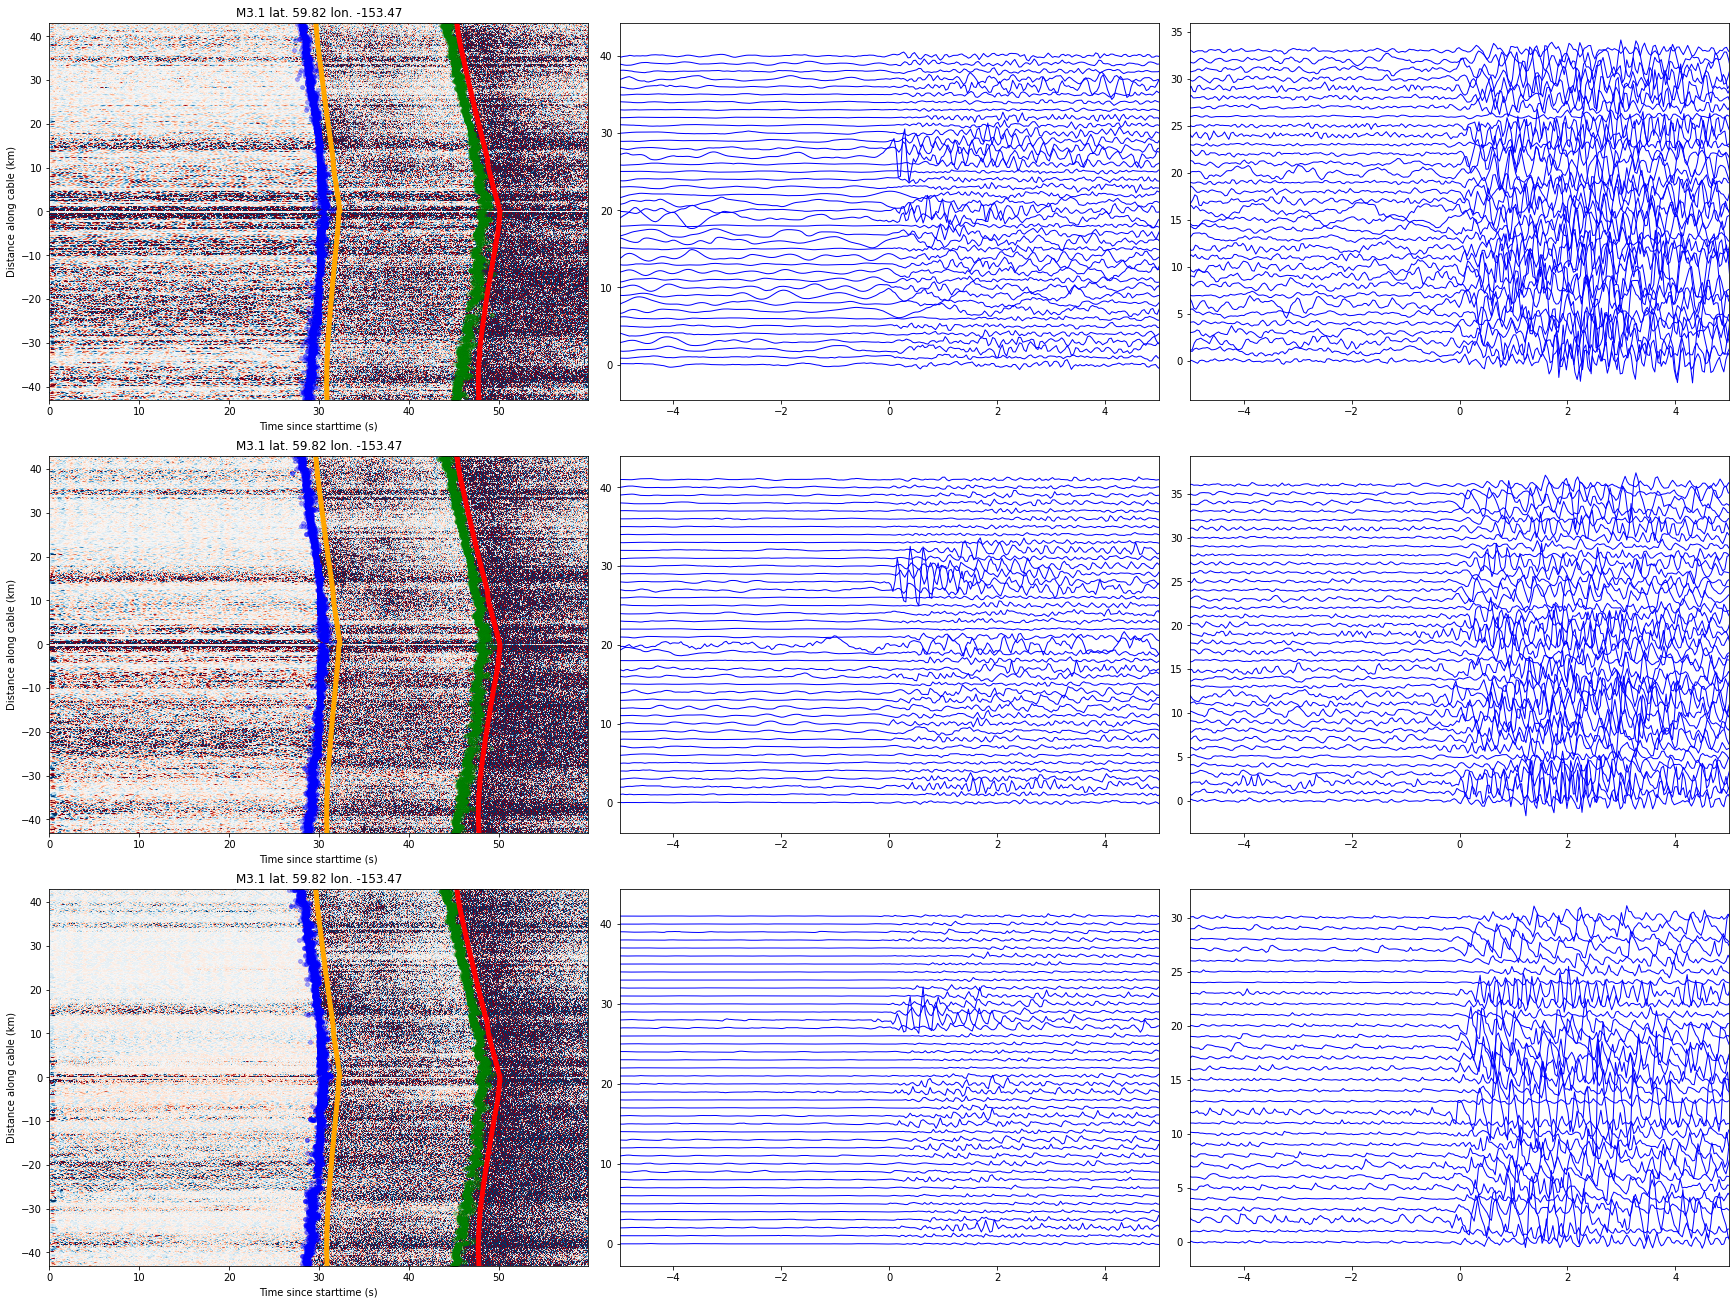

In [77]:
%matplotlib inline

### To plot 
### 1. DAS data
### 2. picked traces aligned by picks, 
### 3. by pred
### 4. stacked traces by picks and pred

ch_itv=2  # data are downsampled to pick
dchan=9.5714
fs=25
st, ed = 5, 55
tax=np.arange(inp_data.shape[2])/fs
win=np.where(np.logical_and(tax>st,tax<ed))[0]


### Choose 1 event from the catalog
i = 0
evt = cat1[i]
mag = evt.magnitudes[0].mag
lon = evt.origins[0].longitude
lat = evt.origins[0].latitude
dep = evt.origins[0].depth/1000
ort = evt.origins[0].time

mag0, lon0, lat0, dep0, ort0= \
round(mag,1), round(lon,2), round(lat,2), round(dep,0), ort.strftime('%Y-%m-%d')

plt.figure(figsize=(24, 18), constrained_layout=True)

### Raw data
image = np.nan_to_num(inp_data[i,::ch_itv,:])
offset_s, std_raw_s, mean_offset_s, ind_s = fit_series(
    raw_picks[i,:,1,0], pred_picks[i,:,1], raw_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)

offset_p, std_raw_p, mean_offset_p, ind_p = fit_series(
    raw_picks[i,:,0,0], pred_picks[i,:,0], raw_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)

plt.subplot(3, 3, 1) 
subfig_img(image, raw_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv],
            "M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))

plt.subplot(3, 3, 2)
for j, ch in enumerate(ind_p[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,0,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)

plt.subplot(3, 3, 3)
for j, ch in enumerate(ind_s[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,1,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)


          
### one denoised
image = np.nan_to_num(one_denoised[i,::ch_itv,:])
offset_s, std_raw_s, mean_offset_s, ind_s = fit_series(
    one_picks[i,:,1,0], pred_picks[i,:,1], one_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)

offset_p, std_raw_p, mean_offset_p, ind_p = fit_series(
    one_picks[i,:,0,0], pred_picks[i,:,0], one_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)

plt.subplot(3, 3, 4) 
subfig_img(image, one_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv],
            "M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))

plt.subplot(3, 3, 5)
for j, ch in enumerate(ind_p[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,0,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)

plt.subplot(3, 3, 6)
for j, ch in enumerate(ind_s[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,1,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)



### mul denoised
image = np.nan_to_num(mul_denoised[i,::ch_itv,:])
offset_s, std_raw_s, mean_offset_s, ind_s = fit_series(
    mul_picks[i,:,1,0], pred_picks[i,:,1], mul_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)

offset_p, std_raw_p, mean_offset_p, ind_p = fit_series(
    mul_picks[i,:,0,0], pred_picks[i,:,0], mul_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)

plt.subplot(3, 3, 7) 
subfig_img(image, mul_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv],
            "M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))

plt.subplot(3, 3, 8)
for j, ch in enumerate(ind_p[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,0,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)

plt.subplot(3, 3, 9)
for j, ch in enumerate(ind_s[::100]): 
    int0 = image[ch]
    int1 = cumulative_trapezoid(int0, tax, initial=0)
    int1 = (int1-np.mean(int1))*10
    # int2 = cumulative_trapezoid(int1, tax, initial=0)
    plt.plot(tax[win]-raw_picks[i,ch,1,0], int0[win]/2+j, color='blue', linestyle='-', lw=1)
           
plt.xlim(-5, 5)


